In [126]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import sys
import os
# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import utils

importlib.reload(utils)
from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"

# Exploratory Data Analysis of Pacman gathered data (Updated to 2024-12-30)

In [127]:
## Read tables from csv
BANNED_USERS = [42]

user_df = pd.read_csv("../data/user.csv")
ip_df = pd.read_csv("../data/userip.csv")
redcap_df = pd.read_csv("../data/redcapdata.csv")
game_df = pd.read_csv(
    "../data/game.csv", converters={"date_played": lambda x: pd.to_datetime(x)}
)
game_df = game_df[~game_df["user_id"].isin(BANNED_USERS)]  # Remove user 42 (myself)
# game_df = game_df[game_df['user_id'] != 47]
gamestate_df = pd.read_csv(
    "../data/gamestate.csv", converters={"user_id": lambda x: int(x)}
)
gamestate_df = gamestate_df[
    ~gamestate_df["game_id"].isin(
        game_df.loc[game_df["user_id"].isin(BANNED_USERS), "game_id"]
    )
]  # Remove games associated with userid 42 (myself)
psychometrics_df = pd.read_csv("..\data\psych\AiPerCogPacman_DATA_2025-04-01_1343.csv")

In [128]:
## Inspect data

user_df.info()
game_df.info()
gamestate_df.info()


user_df.head()
game_df.head()
gamestate_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   150 non-null    int64 
 1   username  150 non-null    object
 2   password  150 non-null    object
 3   email     150 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 4 to 861
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             855 non-null    int64         
 1   user_id             855 non-null    int64         
 2   session_number      855 non-null    int64         
 3   game_in_session     855 non-null    int64         
 4   total_games_played  855 non-null    int64         
 5   source              855 non-null    object        
 6   date_played         855 non-null    datetime64[ns]
 7   game_dura

,game_state_id,game_id,time_elapsed,score,lives,pacman_attack,input_direction,movement_direction,Pacman_X,Pacman_Y,...,ghost3_state,ghost4_state,powerPellets,pellets,powerpelletstate_1,powerpelletstate_2,powerpelletstate_3,powerpelletstate_4,fruitState_1,fruitState_2
0,214062,382,0.19,0,3,0,NaN,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
1,214063,382,0.23,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
2,214064,382,0.29,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
3,214065,382,0.33,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
4,214066,382,0.39,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0


In [129]:
game_df[["game_duration"]].describe()

,game_duration
count,855.000000
mean,58.395628
std,36.623574
min,4.155000
25%,47.114500
50%,59.630000
75%,72.118000
max,933.101000


In [130]:
# Aggregated data per participant
agg = game_df.groupby("user_id").agg(
    {
        "game_duration": "mean",
        "level": "max",
        "game_id": "count",
        "game_in_session": "max",
        "session_number": "max",
        "win": "sum",
    }
)
agg["losses"] = agg["game_id"] - agg["win"]

agg["winrate"] = agg["win"] / agg["game_id"]

agg.rename(
    columns={
        "game_duration": "avg_game_duration",
        "level": "max_level",
        "game_id": "games_played",
        "game_in_session": "longest_session",
        "session_number": "amount_sessions",
        "win": "wins",
    },
    inplace=True,
)

agg.sort_values(by="losses", ascending=False)

agg.describe()

,avg_game_duration,max_level,games_played,longest_session,amount_sessions,wins,losses,winrate
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,60.669812,2.298077,8.221154,6.605769,1.432692,3.519231,4.701923,0.339834
std,22.767471,1.197731,10.076365,6.641175,1.356498,5.409414,5.393055,0.260065
min,37.798000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,53.023583,1.000000,3.000000,3.000000,1.000000,0.000000,2.000000,0.000000
50%,58.248603,2.000000,5.000000,4.000000,1.000000,2.000000,3.000000,0.387500
75%,63.595399,3.000000,10.000000,6.000000,1.000000,4.000000,5.000000,0.500000
max,272.720750,5.000000,71.000000,37.000000,12.000000,36.000000,35.000000,0.800000


In [131]:
agg.loc[agg["games_played"] >= 10].__len__()

27

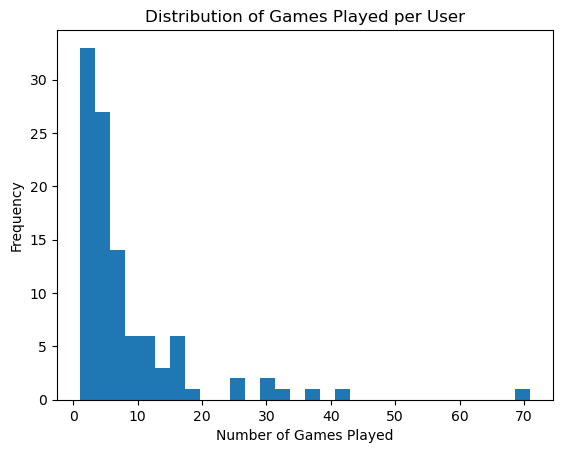

In [132]:
# Descriptive statistic of main variables.

# Distribution of games played per user

user_game_counts = game_df.groupby("user_id").size()
plt.hist(user_game_counts, bins=30)
plt.xlabel("Number of Games Played")
plt.ylabel("Frequency")
plt.title("Distribution of Games Played per User")
plt.show()

In [133]:
game_df.loc[game_df["game_duration"] > 500, "game_id"]

35    419
Name: game_id, dtype: int64

An outlier in game duration was identified. This is game id 419, and it was probably due to a bug (game freeze?).

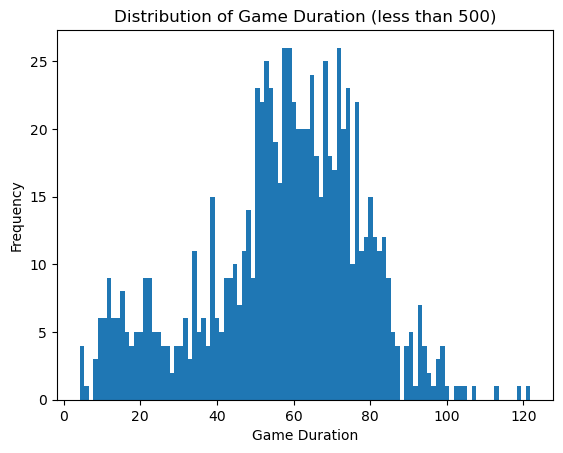

In [134]:
# Distribution of game duration
import matplotlib.pyplot as plt

plt.hist(game_df.loc[game_df["game_duration"] < 500, "game_duration"], bins=100)
plt.xlabel("Game Duration")
plt.ylabel("Frequency")
plt.title("Distribution of Game Duration (less than 500)")
plt.show()

In [135]:
# Distribution of games played per level
game_df.groupby("level").size()

level
1    493
2    244
3     76
4     33
5      9
dtype: int64

In [136]:
# random_record_id = psychometrics_df["record_id"].sample(n=1).iloc[0]
# psychometrics_df.loc[psychometrics_df["record_id"] == random_record_id]

In [137]:
bisbas_df = psychometrics_df.loc[
    ~psychometrics_df["redcap_repeat_instrument"].isin(["flow", "sam"])
    & psychometrics_df["consent_timestamp"].notna()
    & (psychometrics_df["record_id"] > 60)
]

bisbas_df = bisbas_df.iloc[:, 5:34]

bisbas_df.describe()

,age,gender,gender_other,edu,experience,consent_answer,bis_1,bis_2,bis_3,bis_4,...,rew_4,rew_5,drive_1,drive_2,drive_3,drive_4,fun_1,fun_2,fun_3,fun_4
count,112.000000,112.000000,0.0,112.000000,105.000000,112.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,28.705357,1.758929,NaN,4.241071,1.152381,0.991071,2.900901,3.153153,3.027027,3.279279,...,3.378378,3.117117,2.558559,2.567568,2.495495,1.981982,2.819820,2.900901,3.072072,2.531532
std,7.831144,0.700650,NaN,0.960907,0.361113,0.094491,0.762233,0.776919,0.768227,0.776603,...,0.661322,0.759650,0.794123,0.837980,0.761265,0.738327,0.875922,0.797211,0.709823,0.784159
min,20.000000,1.000000,NaN,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,23.750000,1.000000,NaN,4.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,2.000000,2.000000,2.000000,1.500000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,2.000000,NaN,4.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,31.000000,2.000000,NaN,5.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000
max,59.000000,4.000000,NaN,6.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


## Psych and Performance 



In [138]:
from src.datahandlers import PacmanDataReader
## TODO include this psych preproc in the DataReader class
data = PacmanDataReader(data_folder="../data/", read_games_only=False)

user_df = data.user_df
game_df = data.game_df
gamestate_df = data.gamestate_df
psychometrics_df = data.psychometrics_df


In [139]:

whole_games = game_df.loc[(game_df["win"] == 0)]

whole_games_scores = gamestate_df.loc[gamestate_df["game_id"].isin(whole_games["game_id"])].groupby("game_id").agg(
    {"score":"max"}
)

whole_games = pd.merge(whole_games, whole_games_scores, how="outer", on="game_id")

whole_games['total_whole_games_played'] = whole_games.groupby('user_id').cumcount() + 1




In [140]:

flow_items = ["fss_1",
              "fss_2", 
              "fss_3", 
              "fss_4", 
              "fss_5", 
              "fss_6", 
              "fss_7", 
              "fss_8"]

flow = psychometrics_df.loc[psychometrics_df[
    "redcap_repeat_instrument"] == "flow"].loc[:,
                                               ["record_id", 
                                                "total_games_flow", 
                                                "redcap_repeat_instance"] + flow_items]


whole_games.loc[:,["user_id", "game_id", "score", "total_games_played"]].__len__()

flow = flow.rename(columns={
    "record_id": "user_id",
    "total_games_flow": "total_games_played"
})

flow["FLOW"] = flow.iloc[:, 3:].sum(axis=1)

flow = flow.drop(columns=flow_items)



In [141]:
import numpy as np

perf_psych_df = pd.merge(flow,
    whole_games[["user_id", "total_games_played", "total_whole_games_played", "game_id", "score"]],
    on=["user_id", "total_games_played"],
    how="right"
).dropna()

perf_psych_df["score_log"] = np.log(perf_psych_df["score"])
perf_psych_df["inv(score)"] = 1 / perf_psych_df["score"]
perf_psych_df["log(inv(score))"] = np.log(perf_psych_df["inv(score)"])

perf_psych_df["log(total_whole_games_played)"] = np.log(perf_psych_df["total_whole_games_played"]) ## i.e., cum trials

perf_psych_df["flow_z_score"] = perf_psych_df.groupby("user_id")["FLOW"].transform(lambda x: (x - x.mean()) / x.std())

# Calculate deviation from linear regression for each participant
from sklearn.linear_model import LinearRegression

# Initialize lists to store results
user_ids = []
deviations = []

# Group by user_id and calculate deviation for each user
for user_id, user_data in perf_psych_df.groupby('user_id'):
    # Prepare data
    X = user_data[['total_whole_games_played']]
    y = user_data['log(inv(score))']
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate predicted values
    y_pred = model.predict(X)
    
    # Calculate deviation (real - predicted)
    deviation = y - y_pred
    
    # Store results
    user_ids.extend([user_id] * len(deviation))
    deviations.extend(deviation)

# Add deviation column to dataframe
perf_psych_df['score_deviation'] = deviations


# Get users with more than 8 total whole games
users_with_many_games = perf_psych_df.groupby('user_id')['total_whole_games_played'].max() > 9
users_to_keep = users_with_many_games[users_with_many_games].index
perf_psych_df = perf_psych_df[perf_psych_df['user_id'].isin(users_to_keep)]

# Count unique users after filtering
print(perf_psych_df.loc[:,"user_id"].unique().__len__())

perf_psych_df

11


,user_id,total_games_played,redcap_repeat_instance,FLOW,total_whole_games_played,game_id,score,score_log,inv(score),log(inv(score)),log(total_whole_games_played),flow_z_score,score_deviation
5,69,2.0,1.0,32.0,2,399,2650,7.882315,0.000377,-7.882315,0.693147,-0.783373,-0.434609
6,69,3.0,2.0,24.0,3,400,2750,7.919356,0.000364,-7.919356,1.098612,-1.515877,0.411631
7,69,4.0,3.0,36.0,4,401,3000,8.006368,0.000333,-8.006368,1.386294,-0.417121,0.000000
8,69,5.0,4.0,30.0,5,402,2240,7.714231,0.000446,-7.714231,1.609438,-0.966499,0.000000
9,69,7.0,5.0,56.0,6,404,7470,8.918650,0.000134,-8.918650,1.791759,1.414140,0.011960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,201,10.0,7.0,28.0,8,1179,5030,8.523175,0.000199,-8.523175,2.079442,-1.234653,-0.126194
454,201,12.0,8.0,34.0,9,1181,5760,8.658693,0.000174,-8.658693,2.197225,0.705516,-0.214768
455,201,13.0,9.0,33.0,10,1182,2930,7.982758,0.000341,-7.982758,2.302585,0.382155,0.508110
456,201,15.0,10.0,35.0,11,1184,6930,8.843615,0.000144,-8.843615,2.397895,1.028878,-0.305805


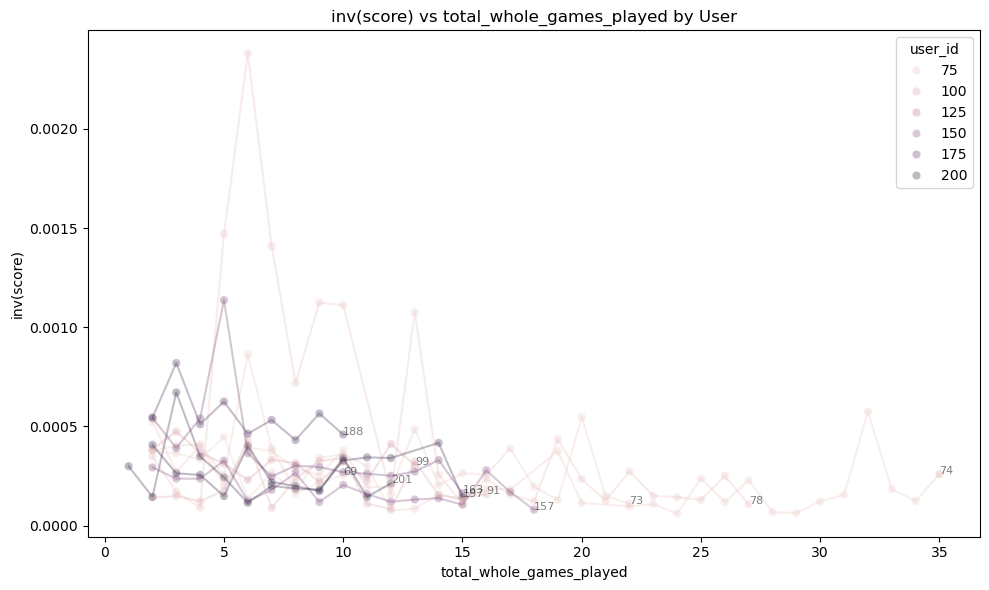

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

x = "total_whole_games_played"
y = "inv(score)"

plt.figure(figsize=(10,6))

sns.scatterplot(data=perf_psych_df, 
                x=x, 
                y=y, 
                hue='user_id',
                alpha=0.31)

# Add user_id labels to each point
for user_id in perf_psych_df['user_id'].unique():
    user_data = perf_psych_df[perf_psych_df['user_id'] == user_id]
    last_row = user_data.iloc[-1]  # Get the last row for each user
    plt.annotate(str(int(user_id)), 
                (last_row[x], last_row[y]),  # Fixed x,y order to match scatterplot
                fontsize=8,
                alpha=0.5)
    
sns.lineplot(data=perf_psych_df, 
             x=x, 
             y=y,
             hue='user_id',
             alpha=0.3,
             legend=False)

plt.title(f'{y} vs {x} by User')
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')


plt.tight_layout()
plt.show()

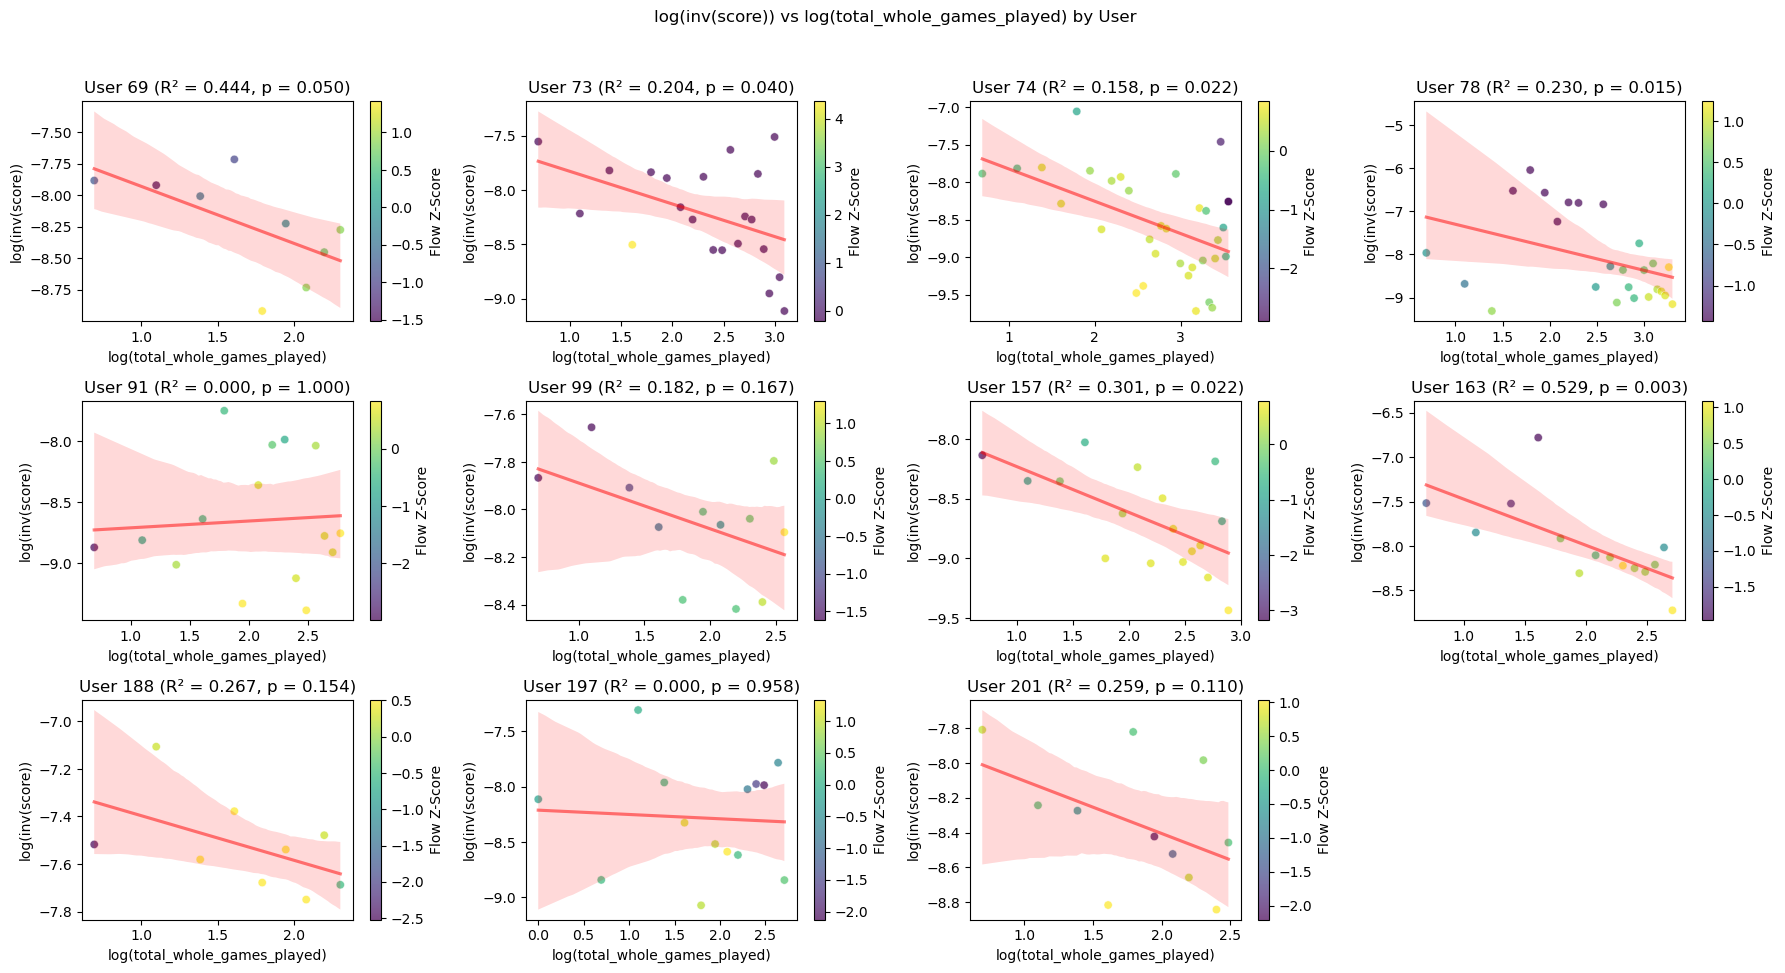

In [143]:
from scipy import stats
# Calculate number of subplots needed
n_users = len(perf_psych_df['user_id'].unique())
m = int(np.ceil(np.sqrt(n_users)))

# Variable names (columns)
x = "log(total_whole_games_played)"
y = "log(inv(score))"

# Create subplots
fig, axes = plt.subplots(m, m, figsize=(18, 12))
fig.suptitle(f'{y} vs {x} by User', y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each user
for i, user_id in enumerate(perf_psych_df['user_id'].unique()):
    user_data = perf_psych_df[perf_psych_df['user_id'] == user_id]
    
    # Calculate Spearman correlation and R^2
    corr, p_value = stats.spearmanr(user_data[x], user_data[y])
    r_squared = corr ** 2
    
    scatter = sns.scatterplot(data=user_data,
                   x=x,
                   y=y,
                   c=user_data['flow_z_score'],
                   cmap='viridis',
                   ax=axes[i],
                   alpha=0.7)
    
    # Add colorbar for each subplot
    plt.colorbar(scatter.collections[0], ax=axes[i], label='Flow Z-Score')
    
    sns.regplot(data=user_data,
                x=x,
                y=y,
                ax=axes[i],
                scatter=False,
                color='red',
                line_kws={'alpha': 0.5})
    
    # Add R^2 value to plot title
    axes[i].set_title(f'User {user_id} (R² = {r_squared:.3f}, p = {p_value:.3f})')
    axes[i].set_xlabel(f'{x}')
    axes[i].set_ylabel(f'{y}')

# Hide empty subplots
for i in range(n_users, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


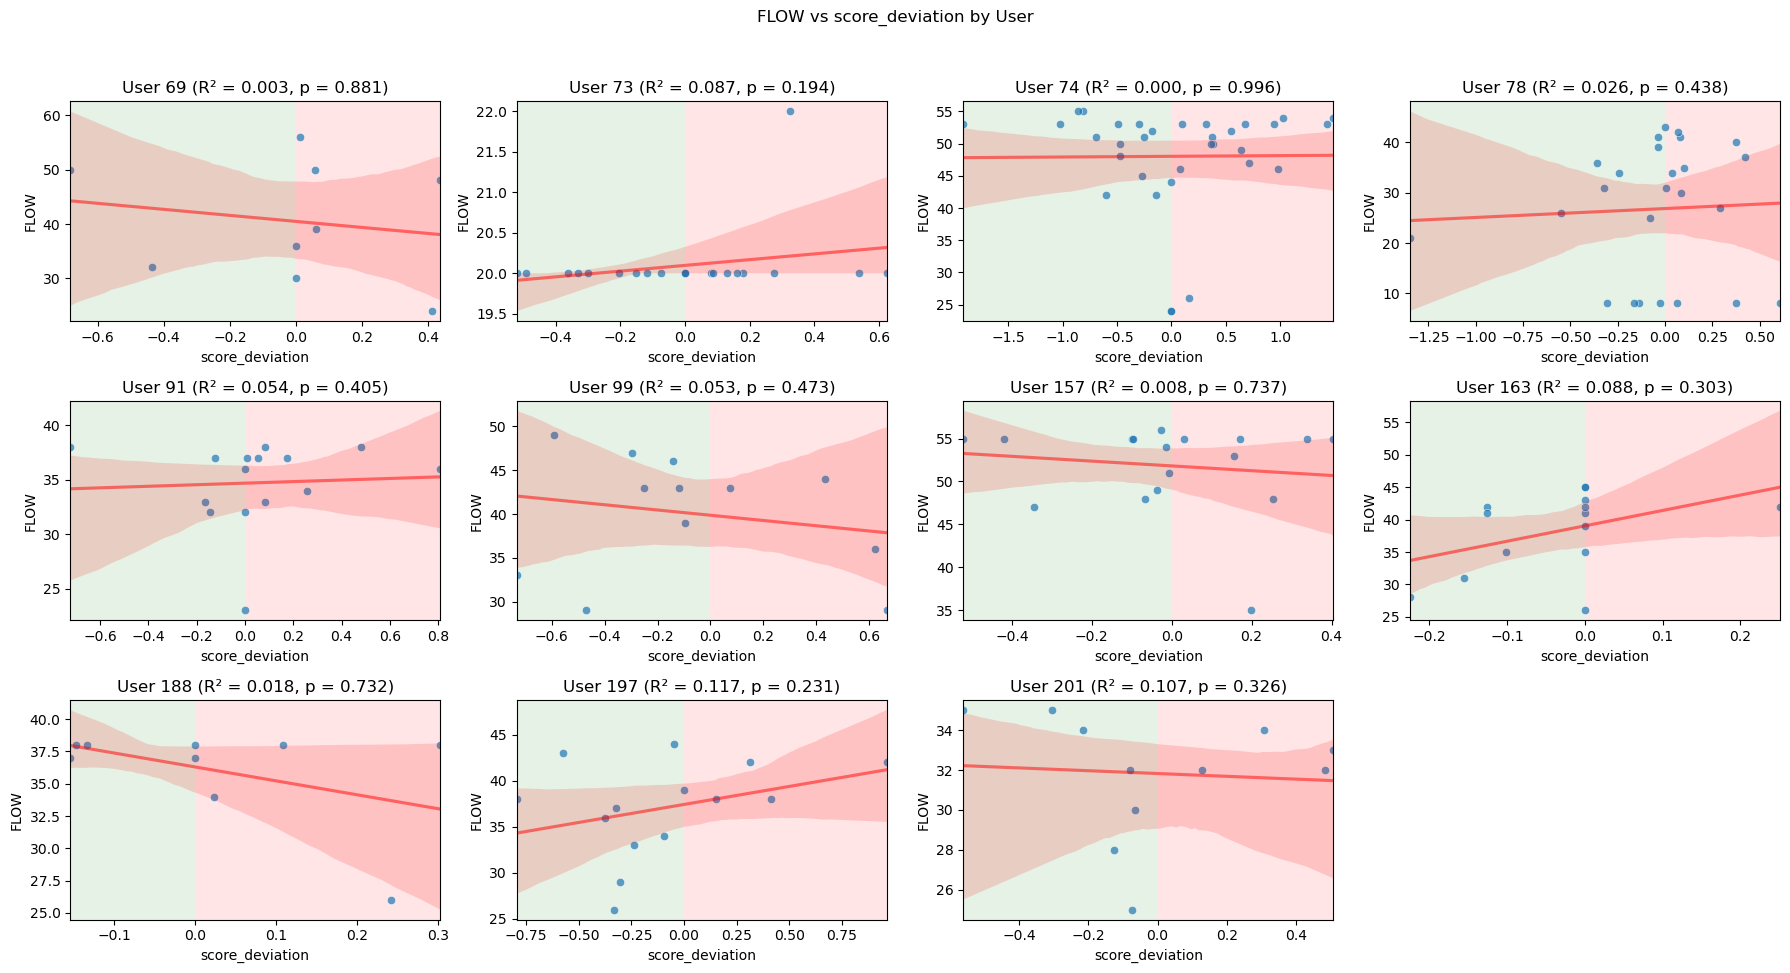

In [144]:
from scipy import stats
# Calculate number of subplots needed
n_users = len(perf_psych_df['user_id'].unique())
m = int(np.ceil(np.sqrt(n_users)))

# Variable names (columns)
x = "score_deviation"
y = "FLOW"

# Create subplots
fig, axes = plt.subplots(m, m, figsize=(18, 12))
fig.suptitle(f'{y} vs {x} by User', y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each user
for i, user_id in enumerate(perf_psych_df['user_id'].unique()):
    user_data = perf_psych_df[perf_psych_df['user_id'] == user_id]
    
    # Calculate Spearman correlation and R^2
    corr, p_value = stats.spearmanr(user_data[x], user_data[y])
    r_squared = corr ** 2
    
    # Add colored background
    axes[i].set_xlim(left=user_data[x].min(), right=user_data[x].max())
    axes[i].axvspan(xmin=axes[i].get_xlim()[0], xmax=0, facecolor='green', alpha=0.1)
    axes[i].axvspan(xmin=0, xmax=axes[i].get_xlim()[1], facecolor='red', alpha=0.1)
    
    scatter = sns.scatterplot(data=user_data,
                   x=x,
                   y=y,
                   ax=axes[i],
                   alpha=0.7)
    
    sns.regplot(data=user_data,
                x=x,
                y=y,
                ax=axes[i],
                scatter=False,
                color='red',
                line_kws={'alpha': 0.5})
    
    # Add R^2 value to plot title
    axes[i].set_title(f'User {user_id} (R² = {r_squared:.3f}, p = {p_value:.3f})')
    axes[i].set_xlabel(f'{x}')
    axes[i].set_ylabel(f'{y}')

# Hide empty subplots
for i in range(n_users, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()



In [145]:
# Calculate Spearman correlation between score and total games played for each user
from scipy import stats

# Group by user_id and calculate correlation
correlations = perf_psych_df.groupby('user_id').apply(
    lambda x: stats.spearmanr(x['score'], x['total_whole_games_played'])
)

# Convert to DataFrame for better readability
corr_df = pd.DataFrame({
    'user_id': correlations.index,
    'correlation': correlations.apply(lambda x: x[0]),
    'p_value': correlations.apply(lambda x: x[1])
})

# Display results
print("Spearman correlations between score and total games played by user:")
corr_df

Spearman correlations between score and total games played by user:


C:\Users\Localadmin_pabflore\AppData\Local\Temp\ipykernel_9252\4008388691.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = perf_psych_df.groupby('user_id').apply(


,user_id,correlation,p_value
user_id,,,
69,69,0.666667,0.049867
73,73,0.451445,0.039950
74,74,0.397961,0.021812
78,78,0.479231,0.015356
91,91,0.000000,1.000000
99,99,0.426573,0.166700
157,157,0.549020,0.022461
163,163,0.727473,0.003191
188,188,0.516667,0.154390


In [146]:

plt.figure(figsize=(10,6))

sns.scatterplot(data=perf_psych_df, 
                x='total_whole_games_played_log', 
                y='score_log', 
                hue='user_id',
                alpha=0.31)
for user_id in perf_psych_df['user_id'].unique():
    user_data = perf_psych_df[perf_psych_df['user_id'] == user_id]
    sns.regplot(data=user_data,
                x='total_whole_games_played_log',
                y='score_log',
                scatter=False,
                color=None,
                line_kws={'alpha': 0.2},
                ci=None)
sns.lineplot(data=perf_psych_df, 
             x='total_whole_games_played_log', 
             y='score_log',

             hue='user_id',
             alpha=0.3,
             legend=False)

plt.title('Log(score) vs Total Games Played by User')
plt.xlabel('Total Games Played')
plt.ylabel('Log(score)')


plt.tight_layout()
plt.show()


ValueError: Could not interpret value `total_whole_games_played_log` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

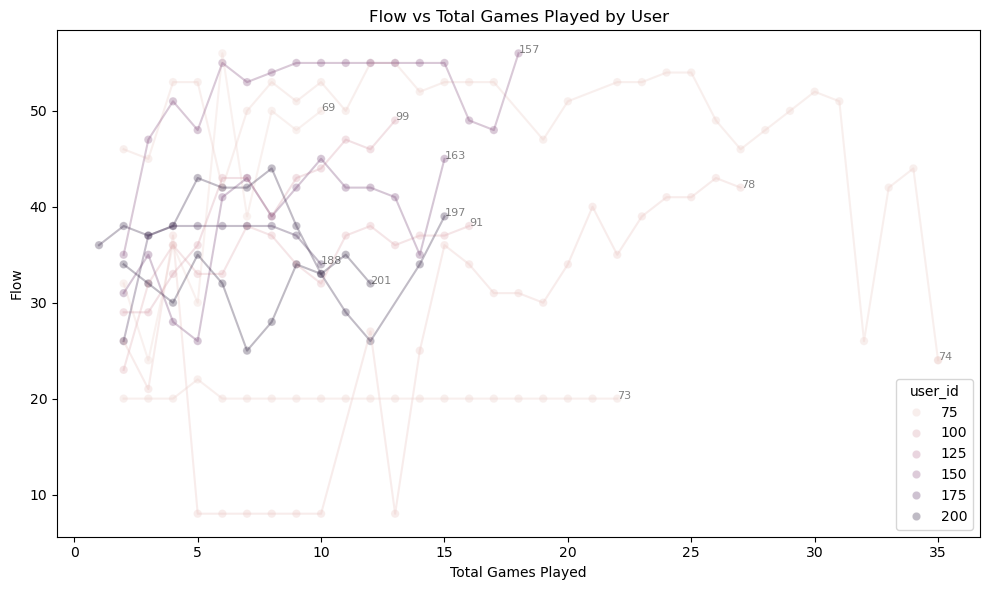

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.scatterplot(data=perf_psych_df, 
                x='total_whole_games_played', 
                y='FLOW', 
                hue='user_id',
                alpha=0.3)

# Add user_id labels to each point
for user_id in perf_psych_df['user_id'].unique():
    user_data = perf_psych_df[perf_psych_df['user_id'] == user_id]
    last_row = user_data.iloc[-1]  # Get the last row for each user
    plt.annotate(str(int(user_id)), 
                (last_row['total_whole_games_played'], last_row['FLOW']),
                fontsize=8,
                alpha=0.5)

sns.lineplot(data=perf_psych_df, 
             x='total_whole_games_played', 
             y='FLOW', 
             hue='user_id',
             alpha=0.3,
             legend=False)

plt.title('Flow vs Total Games Played by User')
plt.xlabel('Total Games Played')
plt.ylabel('Flow')
plt.tight_layout()
plt.show()


In [82]:
from scipy import stats

# Calculate correlation and p-value
corr, p_value = stats.pearsonr(perf_psych_df['score'], perf_psych_df['FLOW'])

# Print results
print(f"Pearson correlation coefficient: {corr:.3f}")
print(f"P-value: {p_value}")
print(f"R-squared: {corr**2:.3f}")

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(perf_psych_df['score'], perf_psych_df['FLOW'])
print(f"\nLinear regression results:")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err:.3f}")

Pearson correlation coefficient: 0.444
P-value: 4.3753634329588466e-10
R-squared: 0.197

Linear regression results:
Slope: 0.002
Intercept: 28.190
R-squared: 0.197
P-value: 4.3753634329585824e-10
Standard error: 0.000


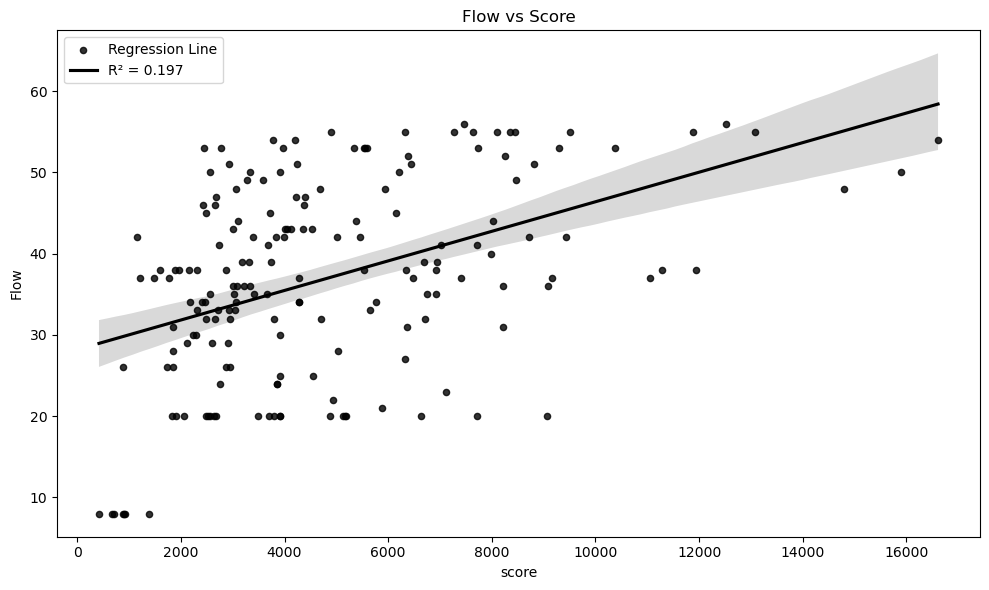

In [ ]:
plt.figure(figsize=(10, 6))
# sns.scatterplot(data=perf_psych_df, 
#                 x='score', 
#                 y='FLOW', 
#                 hue='user_id',
#                 alpha=0.3)

sns.regplot(data=perf_psych_df,
            x='score',
            y='FLOW',
            scatter=True,
            color='black',
            ci=95,
            label='Regression Line',
            scatter_kws={'s': 20},
            line_kws={'label': f'R² = {perf_psych_df[["score", "FLOW"]].corr().iloc[0,1]**2:.3f}'})


plt.title('Flow vs Score')
plt.xlabel('score')
plt.ylabel('Flow')
plt.legend()
plt.tight_layout()
plt.show()


In [84]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

# Assuming we have perf_psych_df from the previous code
# We'll create a mixed linear model with:
# - Fixed effect: total_games_played (to capture learning/experience)
# - Random effect: user_id (to account for individual differences)
# - Dependent variable: score
# - Additional fixed effect: FLOW (to see its relationship with performance)

# First ensure user_id is treated as categorical
perf_psych_df['user_id'] = perf_psych_df['user_id'].astype('category')

# Fit the mixed linear model
model = MixedLM(
    endog=perf_psych_df['score'],
    exog=sm.add_constant(perf_psych_df[['total_games_played', 'FLOW']]),
    groups=perf_psych_df['user_id']
)

result = model.fit()

# Print the results
print(result.summary())
result

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     score       
No. Observations:      180         Method:                 REML        
No. Groups:            11          Scale:                  4858452.0817
Min. group size:       9           Log-Likelihood:         -1635.0567  
Max. group size:       33          Converged:              Yes         
Mean group size:       16.4                                            
-----------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------
const                -2120.132  942.638 -2.249 0.025 -3967.668 -272.595
total_games_played      71.181   12.797  5.562 0.000    46.100   96.262
FLOW                   151.928   22.746  6.679 0.000   107.347  196.509
Group Var          1584691.458  443.033                                

